# **Generative Adversarial Networks (GANs) in Keras - Deep Convolutional GANs or DCGAN with MNIST**

---


Implement a basic **Generative Adversarial Networks (GANs) or DCGAN** with Keras using the MNIST dataset.



1. Setup & load and prepare the dataset
2. Load and prepare the dataset
3. Define our Generator Model
4. Define our Discriminator Model
5. Define the loss and optimizers
6. Define the training loop
7. Training the model



## **GANs**

![A second diagram of a generator and discriminator](https://github.com/rajeevratan84/ModernComputerVision/raw/main/CleanShot%202021-06-03%20at%209.54.37%402x.png)



## **1. Setup & load and prepare the dataset**

In [ ]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-n1n3gq8x
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-n1n3gq8x
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=184426 sha256=97d1dea65763f305ccf27c25ef8bb319c229c5198b387c7e8d9cca039d436cb5
  Stored in directory: /tmp/pip-ephem-wheel-cache-yfi_9bic/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [ ]:
import os
import PIL
import time
import glob
import imageio
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from IPython import display
from tensorflow.keras import layers

# Download MNIST
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

# Reshape and Normalize
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

# Set Batch and Buffer Size
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

11490434/11490434 [==============================] - 2s 0us/step


## **2. Define our Generator Model**


In [ ]:
# We strat with input of 7 X 7 X 256 and divide by two the filters every layer.
# For example it goes from 256 to 128 to 64 and then to 1 wich is black&white.
# By using stride = (2,2) we multipy the kernel by 2. from 7 to 14 to 28 X 28.
def make_generator_model():

    model = tf.keras.Sequential()

    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model


Plotting image from our untrained generator.

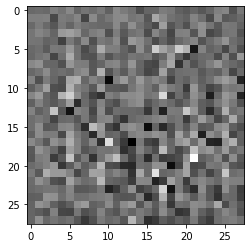

In [ ]:
# Define our Generator
generator = make_generator_model()

# Create a random noise
noise = tf.random.normal([1, 100])

# Create a generated image using generator
generated_image = generator(noise, training=False)

# Plotting our image
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

For now we got only noise.

## **3. Define our Discriminator Model**


In [ ]:
# The discriminator is simply CNN-based image classifier.
def make_discriminator_model():

    model = tf.keras.Sequential()
    
    # Our first CNN Layer using 64 Fitlers of 5x5 size, with stride of 2 & padding 0
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Our first CNN Layer using 128 Fitlers of 5x5 size, with stride of 2 & padding 0
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # We now flatten our previous layers' output 
    model.add(layers.Flatten())
    model.add(layers.Dense(1)) # Note the output is a single binary node

    return model

Now lets use the untrained discriminator to classify the generated images as real or fake. 

The model will be trained to output positive values for real images, and negative values for fake images.

In [ ]:
# Define our discriminator 
discriminator = make_discriminator_model()

# Use the generated image produced by our untrained Generator
decision = discriminator(generated_image)

print(decision)

tf.Tensor([[-0.00105232]], shape=(1, 1), dtype=float32)


## **4. Define the loss and optimizers**

Define loss functions and optimizers for both models.


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### **Discriminator loss**


In [ ]:
# This method quantifies how well the discriminator is able to distinguish real images from fakes
def discriminator_loss(real_output, fake_output):

    # Compera the discriminator's predictions on real images to an array of 1s 
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)

    # Compera the discriminator's predictions on fake (generated) images to an array of 0s.
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

    # Create the total loss of the two above
    total_loss = real_loss + fake_loss

    return total_loss

### **Generator loss**


In [ ]:
# The generator's loss quantifies how well it was able to trick the discriminator. 
# Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1).
def generator_loss(fake_output):

    # Here, compare the discriminators decisions on the generated images to an array of 1s.
    generated_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    
    return generated_loss

### **Optimizers for both models**

In [ ]:
# The discriminator and the generator optimizers are different since you will train two networks separately.
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### **Save checkpoints**

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## **5. Define the training loop**


In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# Ceate this seed to reuse this seed overtime (so it's easier)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a **random seed** as input. 

That seed is used to produce an image. 

The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). 

The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [ ]:
# Notice the use of `tf.function` that causes the function to be "compiled"
@tf.function
def train_step(images):

    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      
         generated_images = generator(noise, training=True)

         real_output = discriminator(images, training=True)
         fake_output = discriminator(generated_images, training=True)

         disc_loss = discriminator_loss(real_output, fake_output)
         gen_loss = generator_loss(fake_output)
         
    # Gradient tape use to update the gradients     
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply gradients for the models
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

### **Generate and save images**


In [ ]:
def generate_and_save_images(model, epoch, test_input):
  
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
def train(dataset, epochs):

  for epoch in range(epochs):
      start = time.time()

      for image_batch in dataset:
          train_step(image_batch)

      # Produce images for the GIF as you go
      display.clear_output(wait=True)
      generate_and_save_images(generator, epoch + 1, seed)

      # Save the model every 15 epochs
      if (epoch + 1) % 15 == 0:
          checkpoint.save(file_prefix = checkpoint_prefix)

      print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

## **6. Training the model**

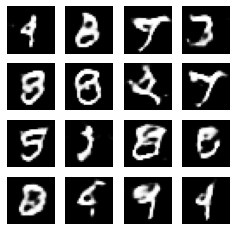

In [ ]:
# Call the `train()` method defined above to train the generator and discriminator simultaneously. 
train(train_dataset, EPOCHS)

In [ ]:
# Restore the latest checkpoint.
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## **7. Output - Let's create a GIF**


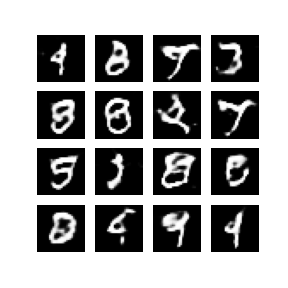

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):

    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))


display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:

     filenames = glob.glob('image*.png')
     filenames = sorted(filenames)

     for filename in filenames:       
         image = imageio.imread(filename)
         writer.append_data(image)

     image = imageio.imread(filename)
     writer.append_data(image)


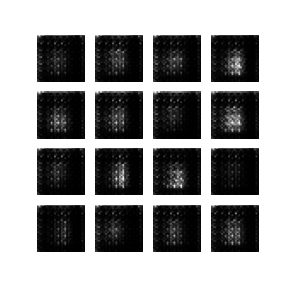

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)